In [46]:
# ref https://www.kaggle.com/eatmygoose/cnn-detection-of-wheezes-and-crackles
import wave
import math
import scipy.io.wavfile as wf
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image as img

In [17]:
def read_wav_file(str_filename, target_rate):
    wav = wave.open(str_filename, mode = 'r')
    (sample_rate, data) = extract2FloatArr(wav,str_filename)
    
    if (sample_rate != target_rate):
        ( _ , data) = resample(sample_rate, data, target_rate)
        
    wav.close()
    return data.astype(np.float32)

def resample(current_rate, data, target_rate):
    x_original = np.linspace(0,100,len(data))
    x_resampled = np.linspace(0,100, int(len(data) * (target_rate / current_rate)))
    resampled = np.interp(x_resampled, x_original, data)
    return (target_rate, resampled.astype(np.float32))

# -> (sample_rate, data)
def extract2FloatArr(lp_wave, str_filename):
    (bps, channels) = bitrate_channels(lp_wave)
    
    if bps in [1,2,4]:
        (rate, data) = wf.read(str_filename)
        divisor_dict = {1:255, 2:32768}
        if bps in [1,2]:
            divisor = divisor_dict[bps]
            data = np.divide(data, float(divisor)) #clamp to [0.0,1.0]        
        return (rate, data)
    
    elif bps == 3: 
        #24bpp wave
        return read24bitwave(lp_wave)
    
    else:
        raise Exception('Unrecognized wave format: {} bytes per sample'.format(bps))
        
#Note: This function truncates the 24 bit samples to 16 bits of precision
#Reads a wave object returned by the wave.read() method
#Returns the sample rate, as well as the audio in the form of a 32 bit float numpy array
#(sample_rate:float, audio_data: float[])
def read24bitwave(lp_wave):
    nFrames = lp_wave.getnframes()
    buf = lp_wave.readframes(nFrames)
    reshaped = np.frombuffer(buf, np.int8).reshape(nFrames,-1)
    short_output = np.empty((nFrames, 2), dtype = np.int8)
    short_output[:,:] = reshaped[:, -2:]
    short_output = short_output.view(np.int16)
    return (lp_wave.getframerate(), np.divide(short_output, 32768).reshape(-1))  #return numpy array to save memory via array slicing

def bitrate_channels(lp_wave):
    bps = (lp_wave.getsampwidth() / lp_wave.getnchannels()) #bytes per sample
    return (bps, lp_wave.getnchannels())

def slice_data(start, end, raw_data,  sample_rate):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sample_rate), max_ind)
    end_ind = min(int(end * sample_rate), max_ind)
    return raw_data[start_ind: end_ind]

In [123]:
def sample2MelSpectrum(cycle_info, sample_rate, n_filters, vtlp_params):
    n_rows = 175 # 7500 cutoff
    n_window = 512 #~25 ms window
    (f, t, Sxx) = scipy.signal.spectrogram(cycle_info,fs = sample_rate, nfft= n_window, nperseg=n_window)
    Sxx = Sxx[:n_rows,:].astype(np.float32) #sift out coefficients above 7500hz, Sxx has 196 columns
    mel_log = FFT2MelSpectrogram(f[:n_rows], Sxx, sample_rate, n_filters, vtlp_params)[1]
    mel_min = np.min(mel_log)
    mel_max = np.max(mel_log)
    diff = mel_max - mel_min
    norm_mel_log = (mel_log - mel_min) / diff if (diff > 0) else np.zeros(shape = (n_filters,Sxx.shape[1]))
    return np.reshape(norm_mel_log, (n_filters,Sxx.shape[1],1)).astype(np.float32) 
        
def Freq2Mel(freq):
    return 1125 * np.log(1 + freq / 700)

def Mel2Freq(mel):
    exponents = mel / 1125
    return 700 * (np.exp(exponents) - 1)

#Tased on Jaitly & Hinton(2013)
#Takes an array of the original mel spaced frequencies and returns a warped version of them
def VTLP_shift(mel_freq, alpha, f_high, sample_rate):
    nyquist_f = sample_rate / 2
    warp_factor = min(alpha, 1)
    threshold_freq = f_high * warp_factor / alpha
    lower = mel_freq * alpha
    higher = nyquist_f - (nyquist_f - mel_freq) * ((nyquist_f - f_high * warp_factor) / (nyquist_f - f_high * (warp_factor / alpha)))
    
    warped_mel = np.where(mel_freq <= threshold_freq, lower, higher)
    return warped_mel.astype(np.float32)

#mel_space_freq: the mel frequencies (HZ) of the filter banks, in addition to the two maximum and minimum frequency values
#fft_bin_frequencies: the bin freqencies of the FFT output
#Generates a 2d numpy array, with each row containing each filter bank
def GenerateMelFilterBanks(mel_space_freq, fft_bin_frequencies):
    n_filters = len(mel_space_freq) - 2
    coeff = []
    #Triangular filter windows
    #ripped from http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
    for mel_index in range(n_filters):
        m = int(mel_index + 1)
        filter_bank = []
        for f in fft_bin_frequencies:
            if(f < mel_space_freq[m-1]):
                hm = 0
            elif(f < mel_space_freq[m]):
                hm = (f - mel_space_freq[m-1]) / (mel_space_freq[m] - mel_space_freq[m-1])
            elif(f < mel_space_freq[m + 1]):
                hm = (mel_space_freq[m+1] - f) / (mel_space_freq[m + 1] - mel_space_freq[m])
            else:
                hm = 0
            filter_bank.append(hm)
        coeff.append(filter_bank)
    return np.array(coeff, dtype = np.float32)
        
#Transform spectrogram into mel spectrogram -> (frequencies, spectrum)
#vtlp_params = (alpha, f_high), vtlp will not be applied if set to None
def FFT2MelSpectrogram(f, Sxx, sample_rate, n_filterbanks, vtlp_params = None):
    (max_mel, min_mel)  = (Freq2Mel(max(f)), Freq2Mel(min(f)))
    mel_bins = np.linspace(min_mel, max_mel, num = (n_filterbanks + 2))
    #Convert mel_bins to corresponding frequencies in hz
    mel_freq = Mel2Freq(mel_bins)
    
    if(vtlp_params is None):
        filter_banks = GenerateMelFilterBanks(mel_freq, f)
    else:
        #Apply VTLP
        (alpha, f_high) = vtlp_params
        warped_mel = VTLP_shift(mel_freq, alpha, f_high, sample_rate)
        filter_banks = GenerateMelFilterBanks(warped_mel, f)
        
    mel_spectrum = np.matmul(filter_banks, Sxx)
    return (mel_freq[1:-1], np.log10(mel_spectrum  + float(10e-12)))

In [124]:
def split_and_pad(original, desiredLength, sampleRate):
    output_buffer_length = int(desiredLength * sampleRate)
    soundclip = original
    n_samples = len(soundclip)
    total_length = n_samples / sampleRate #length of cycle in seconds
    n_slices = int(math.ceil(total_length / desiredLength)) #get the minimum number of slices needed
    samples_per_slice = n_samples // n_slices
    src_start = 0 #Staring index of the samples to copy from the original buffer
    output = [] #Holds the resultant slices
    for i in range(n_slices):
        src_end = min(src_start + samples_per_slice, n_samples)
        length = src_end - src_start
        copy = generate_padded_samples(soundclip[src_start:src_end], output_buffer_length)
        output.append((copy, original[1], original[2]))
        src_start += length
    return output

def generate_padded_samples(source, output_length):
    copy = np.zeros(output_length, dtype = np.float32)
    src_length = len(source)
    frac = src_length / output_length
    if(frac < 0.5):
        #tile forward sounds to fill empty space
        cursor = 0
        while(cursor + src_length) < output_length:
            copy[cursor:(cursor + src_length)] = source[:]
            cursor += src_length
    else:
        copy[:src_length] = source[:]
    #
    return copy
#Creates a copy of each time slice, but stretches or contracts it by a random amount
def gen_time_stretch(original, sample_rate, max_percent_change):
    stretch_amount = 1 + np.random.uniform(-1,1) * (max_percent_change / 100)
    (_, stretched) = resample(sample_rate, original, int(sample_rate * stretch_amount)) 
    return stretched

#Same as above, but applies it to a list of samples
def augment_list(audio_with_labels, sample_rate, percent_change, n_repeats):
    augmented_samples = []
    for i in range(n_repeats):
        addition = [(gen_time_stretch(t[0], sample_rate, percent_change), t[1], t[2] ) for t in audio_with_labels]
        augmented_samples.extend(addition)
    return augmented_samples

#Takes a list of respiratory cycles, and splits and pads each cycle into fixed length buffers (determined by desiredLength(seconds))
#Then takes the split and padded sample and transforms it into a mel spectrogram
#VTLP_alpha_range = [Lower, Upper] (Bounds of random selection range), 
#VTLP_high_freq_range = [Lower, Upper] (-)
#output:[(arr:float[],c:float_bool,w:float_bool),(arr,c,w)]
def split_and_pad_and_apply_mel_spect(original, desiredLength, sampleRate, VTLP_alpha_range = None, VTLP_high_freq_range = None, n_repeats = 1):
    output = []
    for i in range(n_repeats):
        
        lst_result = split_and_pad(d, desiredLength, sampleRate) #Time domain
        if( (VTLP_alpha_range is None) | (VTLP_high_freq_range is None) ):
                #Do not apply VTLP
            VTLP_params = None
        else:
                #Randomly generate VLTP parameters
            alpha = np.random.uniform(VTLP_alpha_range[0], VTLP_alpha_range[1])
            high_freq = np.random.uniform(VTLP_high_freq_range[0], VTLP_high_freq_range[1])
            VTLP_params = (alpha, high_freq)
        freq_result = [sample2MelSpectrum(d, sampleRate, 50, VTLP_params)] #Freq dom
    return freq_result


(50, 357, 1)


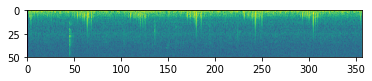

In [157]:
sample_height = output[0].shape[0]
sample_width = output[0].shape[1]
print(output[0].shape)
plt.imshow(output[0].reshape(sample_height, sample_width))
plt.imsave('a.png',output[0].reshape(sample_height, sample_width))

In [163]:
def preprocessing(file_path):
    data=read_wav_file(file_path,22000)
    out_data=split_and_pad_and_apply_mel_spect(data,5,8000)
    sample_height = out_data[0].shape[0]
    sample_width = out_data[0].shape[1]
    plt.imsave('a.png',out_data[0].reshape(sample_height, sample_width))
    data_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
    image=img.open('a.png')
    I=data_transforms(image)
    !rm 'a.png'
    return I
    
    
    

In [164]:
a=preprocessing('Respiratory_Sound_Database/Respiratory_Sound_Database/Audio/176_1b4_Ll_mc_AKGC417L.wav')

In [166]:
print(a)

tensor([[[-0.8164, -0.8678, -0.9192,  ..., -1.0733, -1.1075, -1.1418],
         [-1.0390, -1.0390, -1.0562,  ..., -1.1247, -1.1932, -1.2445],
         [-1.1075, -1.1247, -1.1247,  ..., -1.1760, -1.2445, -1.2959],
         ...,
         [-1.3815, -1.3815, -1.3815,  ..., -1.3130, -1.2959, -1.2788],
         [-1.3815, -1.3815, -1.3815,  ..., -1.3130, -1.2959, -1.2788],
         [-1.3815, -1.3815, -1.3815,  ..., -1.2959, -1.2959, -1.2788]],

        [[ 1.3256,  1.3081,  1.2906,  ...,  1.2206,  1.2031,  1.1856],
         [ 1.2556,  1.2381,  1.2206,  ...,  1.2031,  1.1681,  1.1331],
         [ 1.2206,  1.2031,  1.2031,  ...,  1.1681,  1.1331,  1.1155],
         ...,
         [-0.0049, -0.0399, -0.0399,  ..., -0.1800, -0.2150, -0.2500],
         [-0.0049, -0.0224, -0.0224,  ..., -0.1800, -0.2150, -0.2500],
         [ 0.0126, -0.0049, -0.0049,  ..., -0.1975, -0.2325, -0.2500]],

        [[ 0.0605,  0.0953,  0.1302,  ...,  0.1999,  0.2173,  0.2522],
         [ 0.1825,  0.1999,  0.2173,  ...,  0